In [866]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import gaussian_filter1d

In [ ]:
batch_size = 32
data_size = 5000

def batch_to_epoch(batch):
    batchs_per_epoch = math.ceil(data_size / batch_size)
    return batch / batchs_per_epoch

def epoch_to_batch(epoch):
    batchs_per_epoch = math.ceil(data_size / batch_size)
    return epoch * batchs_per_epoch

In [876]:
def plot_generator_losses(losses, epochs):
    fig, ax = plt.subplots()
    ax.plot(epochs, losses['loss'], label = 'loss')
    ax.plot(epochs, losses['recon_loss'], label = 'recon_loss')
    ax.plot(epochs, losses['perceptual_loss'], label = 'perceptual_loss')
    ax.plot(epochs, losses['commit_loss'], label = 'commit_loss')
    scaled = losses['generator_loss'] * losses['disc_factor'] * losses['adaptive_weight']
    scaled = scaled.to_list()
    ax.plot(epochs, scaled, label = 'scaled gen loss')
    # ax.plot(epochs, losses['generator_loss'], label = 'gen loss')
    # ax.plot(epochs, losses['disc_loss'], label = 'disc_loss')
    ax.set_ylabel("loss")
    ax.set_yscale("log")
    ax.tick_params(axis='y', which='minor', labelleft=True)
    ax.tick_params(axis='y', which='major', width=1.0, length=8, color='black')
    ax.tick_params(axis='y', which='minor', width=0.5, length=4, color='gray')
    ax.set_xlabel("epoch")
    ax.grid(which = "both")
    ax.legend()
    if len(epochs) < 25:
        ax.set_xticks(epochs)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1, 10) * .1)
    ax.yaxis.set_minor_locator(locmin)

def plot_gen_loss_components(losses, epochs):
    fig, ax = plt.subplots()
    ax.plot(epochs, losses['generator_loss'], label = 'gen loss')
    ax.plot(epochs, losses['generator_loss'] * losses['adaptive_weight'] * losses['disc_factor'], label = 'weighted_loss', color = 'green')
    ax2 = ax.twinx()
    ax2.plot(epochs, losses['disc_factor'], label = 'disc_factor', color = 'red')
    ax2.plot(epochs, losses['adaptive_weight'], label = 'adaptive_weight', color = 'orange')
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.set_ylabel("loss")
    ax2.set_ylabel("weight")
    ax.set_yscale("log")
    ax.set_xlabel("epoch")
    ax.grid(which = "both")
    ax.legend(handles = h1 + h2, labels = l1 + l2)
    if len(epochs) < 25:
        ax.set_xticks(epochs)

def plot_disc_loss(losses, epochs):
    fig, ax = plt.subplots()
    ax.plot(epochs, losses['disc_loss'], label = 'disc_loss')
    ax.set_ylabel("loss")
    ax.set_xlabel("epoch")
    ax.grid(which = "both")
    ax.legend()
    if len(epochs) < 25:
        ax.set_xticks(epochs)

def plot_utilizations(losses, epochs):
    fig, ax = plt.subplots()
    ax.plot(epochs, losses['codebook_utilization'], label = 'utilizations')
    ax.set_ylabel("%")
    ax.set_xlabel("epoch")
    ax.grid(which = "both")
    ax.legend()
    if len(epochs) < 25:
        ax.set_xticks(epochs)
    ax.minorticks_on()

def plot_grads_losses(csv, title, key, start = None, end = None, smoothing = 0):
    if start != None and end != None:
        g = pd.read_csv(csv).iloc[start:end]
    else:
        g = pd.read_csv(csv)
        start = 0
        end = len(g)

    fig, ax = plt.subplots()

    if smoothing:
        grad  = gaussian_filter1d(g['grad'], smoothing)
        loss = gaussian_filter1d(g[key], smoothing)
        title_addendum = f'(Smoothing with sigma = {smoothing})'
    else:
        grad = g['grad']
        loss = g[key]
        title_addendum = ''

    
    ax.plot(range(start, end), grad, label = 'grad')
    # ax.set_yscale('symlog')
    ax.set_xlabel('batch')
    ax2 = ax.twinx()
    ax2.plot(range(start, end), loss, label = 'loss', color = 'orange')
    ax.set_ylabel('grad')
    ax2.set_ylabel('loss')
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc = 'upper left')
    ax.set_title(f'{title} {title_addendum}')
    x2 = ax.secondary_xaxis('top', functions = (batch_to_epoch, epoch_to_batch))
    ax.grid(which = "both")
    ax2.set_yscale('symlog')
    if batch_to_epoch(end - start) < 25:
        x2.set_xticks(range(int(batch_to_epoch(end - start))))

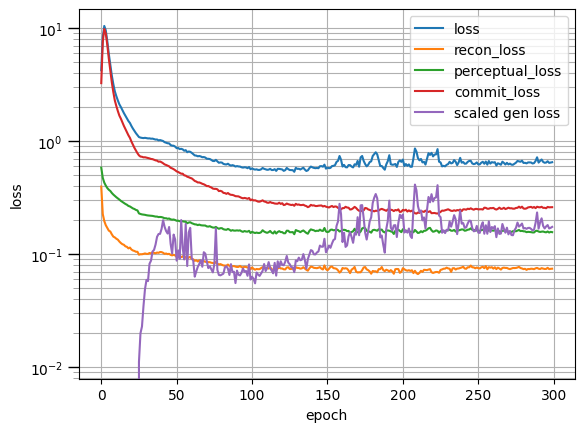

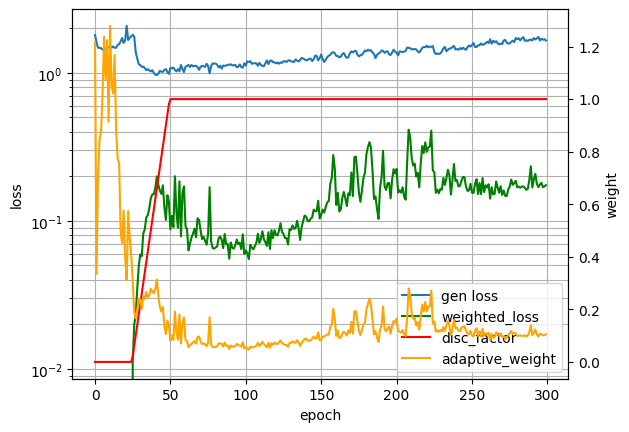

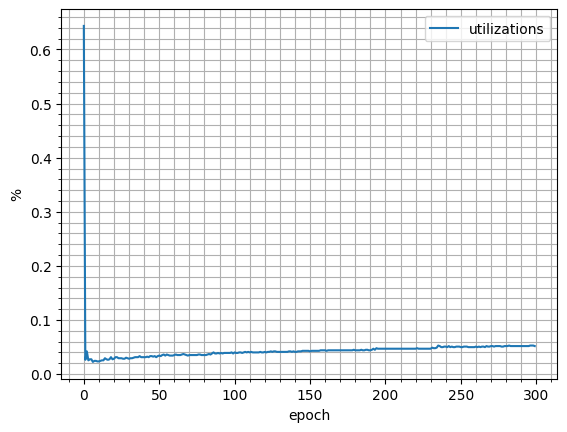

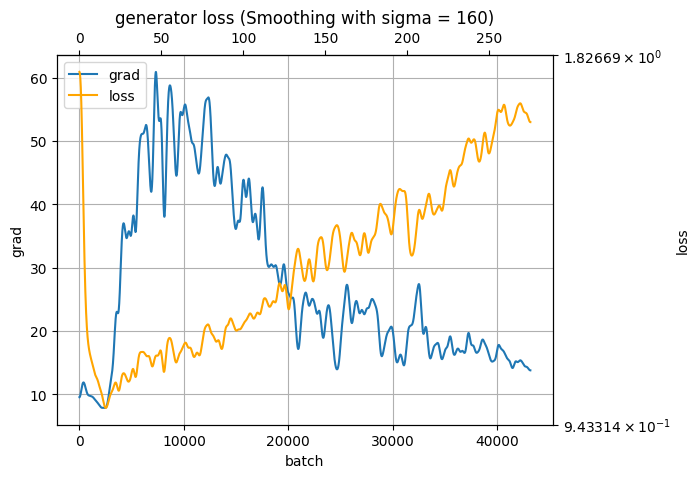

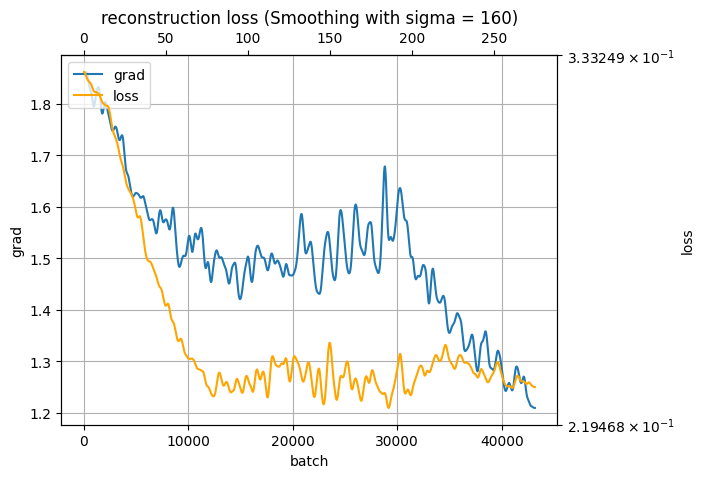

In [877]:
dir = 'vqgan_d_loss_scale'

losses = pd.read_csv(f"checkpoints/{dir}/losses.csv")
epochs = range(len(losses))
plot_generator_losses(losses, epochs)
plot_gen_loss_components(losses, epochs)
plot_utilizations(losses, epochs)
sigma = int((batch_size * data_size) / 1000)
plot_grads_losses('gan_grad.csv', 'generator loss', 'g_loss', smoothing = sigma)
plot_grads_losses('rec_grad.csv', 'reconstruction loss', 'rec_loss', smoothing = sigma)

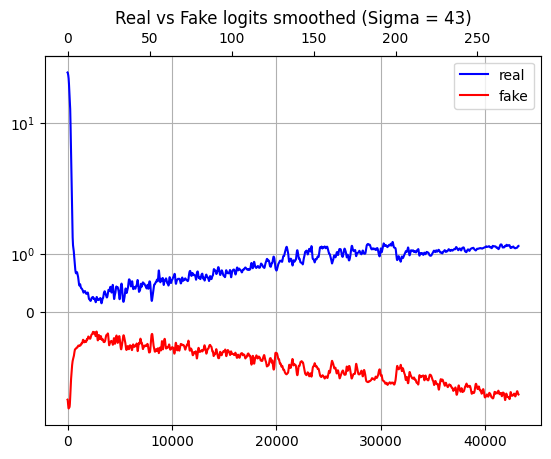

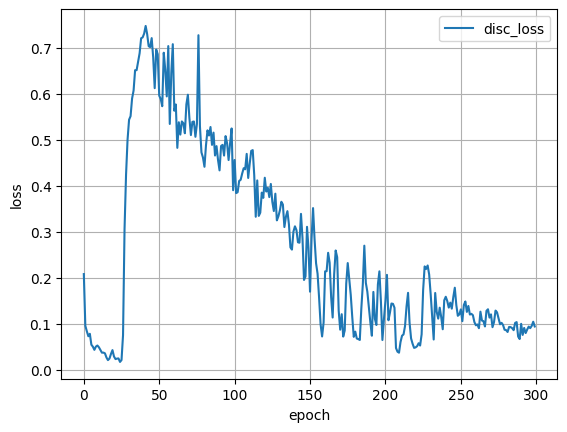

In [ ]:
df = pd.read_csv('logits.csv')
sigma = int(len(df) / 1000)
fig, ax = plt.subplots()
real = gaussian_filter1d(df['r'], sigma)
fake = gaussian_filter1d(df['f'], sigma)
ax.plot(range(len(df)), real, label = 'real', color = 'blue')
ax.plot(range(len(df)), fake, label = 'fake', color = 'red')
ax.set_yscale('symlog')
ax.grid()
ax.legend()
ax.set_title(f'Real vs Fake logits smoothed (sigma = {sigma})')
x2 = ax.secondary_xaxis('top', functions = (batch_to_epoch, epoch_to_batch))

if batch_to_epoch(len(df)) < 25:
    x2.set_xticks(range(int(batch_to_epoch(len(df)))))

losses = pd.read_csv(f"checkpoints/{dir}/losses.csv")
epochs = range(len(losses))
plot_disc_loss(losses, epochs)